In [121]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import joblib

In [122]:
random_state = 20
threshold = 1 # Accuracy scoring threshold

In [123]:
# Import data and preprocess
df = pd.read_csv("test_data/Grounded CPW Leaky Wave antenna/S11 Data.csv")
df = df.drop(df[df['dB(S(1,1)) []'] > 0].index) # Remove all rows with positive s11

In [124]:
df

,Feed_Gap [mm],Feed_Inset [cm],Feed_W [cm],Ground_gap [mm],Pad_L [cm],Pad_W [cm],Freq [GHz],"dB(S(1,1)) []"
0,0.5,0.2,1.2,3,0.70,0.9,2.00,-0.232632
1,0.5,0.2,1.2,3,0.70,0.9,2.09,-0.340011
2,0.5,0.2,1.2,3,0.70,0.9,2.18,-1.501822
3,0.5,0.2,1.2,3,0.70,0.9,2.27,-1.827965
4,0.5,0.2,1.2,3,0.70,0.9,2.36,-0.448171
...,...,...,...,...,...,...,...,...
4216,0.5,0.2,1.2,4,0.75,1.2,19.64,-15.530748
4217,0.5,0.2,1.2,4,0.75,1.2,19.73,-15.681817
4218,0.5,0.2,1.2,4,0.75,1.2,19.82,-15.837634
4219,0.5,0.2,1.2,4,0.75,1.2,19.91,-16.001216


In [125]:
# Split into x and y
input_x = df.drop(columns=['dB(S(1,1)) []'], axis=1)
input_y = df[['dB(S(1,1)) []']]

In [127]:
# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(input_x, input_y, random_state=random_state)

In [129]:
model = DecisionTreeRegressor(random_state=random_state) # Initialize model
scaler = MinMaxScaler(feature_range=(0,1)) # Initialize scaler
pipeline = Pipeline(steps=[('normalize', scaler), ('model', model)]) # Create pipeline with scaler and model

In [130]:
# Train and predict the pipeline
pipeline_fit = pipeline.fit(X_train, y_train)
predictions = pipeline_fit.predict(X_test)

In [132]:
# Check if predicted value is threshold amount above or below actual value
def is_in_threshold(actual, pred):
    return pred <= actual + threshold and pred >= actual - threshold

In [133]:
# Create new boolean column that shows if the test and prediction values are the same
results = X_test.copy()
def create_tf_column(results):
    return results.apply(lambda x: is_in_threshold(x['y_test'], x['predictions']), axis=1)

In [134]:
# Calculate accuracy of model by number of predictions that are within threshold value above or below the test value for each row
def get_score(X_test, y_test, predictions, clf_dt):
    predictions = clf_dt.predict(X_test)
    dataframe = pd.DataFrame(X_test.copy(), columns=input_x.columns)
    dataframe['y_test'] = y_test.values
    dataframe['predictions'] = predictions
    return create_tf_column(dataframe).value_counts().get(True) / dataframe.shape[0]

In [135]:
X_test

,Feed_Gap [mm],Feed_Inset [cm],Feed_W [cm],Ground_gap [mm],Pad_L [cm],Pad_W [cm],Freq [GHz]
3770,0.5,0.2,1.2,4,0.70,1.2,15.68
888,0.2,0.2,1.2,3,0.70,1.0,9.56
1157,0.3,0.2,1.2,3,0.70,1.0,15.68
318,0.5,0.2,1.2,4,0.70,0.9,12.53
2150,0.5,0.2,1.2,4,0.75,1.0,14.60
...,...,...,...,...,...,...,...
3899,0.5,0.2,1.2,3,0.75,1.2,9.20
2613,0.5,0.2,1.2,3,0.70,1.1,2.00
1698,0.5,0.2,1.2,4,0.70,1.0,10.10
92,0.5,0.2,1.2,3,0.70,0.9,10.28


In [136]:
get_score(X_test, y_test, predictions, pipeline)

0.764034253092293

In [137]:

path = model.cost_complexity_pruning_path(X_train, y_train)

In [138]:
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]
ccp_alphas = ccp_alphas[0::50]

In [139]:
clf_dts = []

for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeRegressor(random_state=random_state, ccp_alpha=ccp_alpha)
    clf_dt.fit(X_train, y_train)
    clf_dts.append(clf_dt)

In [140]:
# train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [get_score(X_test, y_test, predictions, clf_dt) for clf_dt in clf_dts]

In [141]:
test_scores

[0.764034253092293,
 0.764034253092293,
 0.764034253092293,
 0.764034253092293,
 0.764034253092293,
 0.764034253092293,
 0.764034253092293,
 0.764034253092293,
 0.764034253092293,
 0.764034253092293,
 0.764034253092293,
 0.764034253092293,
 0.764034253092293,
 0.7630827783063748,
 0.7630827783063748,
 0.7630827783063748,
 0.764034253092293,
 0.764034253092293,
 0.764034253092293,
 0.7649857278782112,
 0.7659372026641293,
 0.7659372026641293,
 0.7659372026641293,
 0.7659372026641293,
 0.7668886774500476,
 0.7697431018078021,
 0.7706945765937203,
 0.7706945765937203,
 0.7697431018078021,
 0.7697431018078021,
 0.7649857278782112,
 0.7611798287345385,
 0.7592768791627021,
 0.758325404376784,
 0.758325404376784,
 0.7564224548049476,
 0.758325404376784,
 0.7611798287345385,
 0.7621313035204567,
 0.7611798287345385,
 0.7564224548049476,
 0.7497621313035204,
 0.7478591817316841,
 0.7421503330161751,
 0.7392959086584205,
 0.7259752616555661,
 0.7126546146527117,
 0.7059942911512845,
 0.68696479

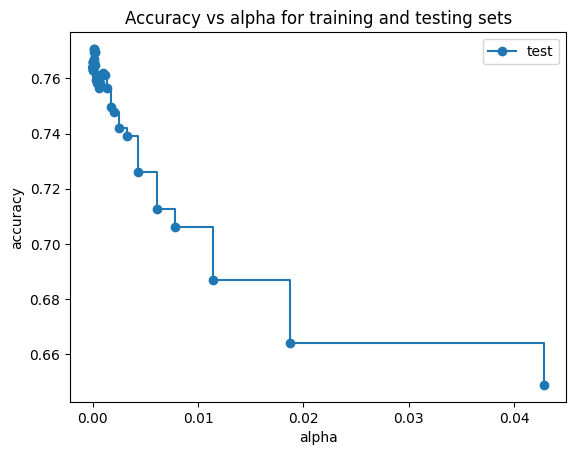

In [142]:
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
# ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test", drawstyle="steps-post")
ax.legend()
plt.show()


In [144]:
# Save model to file
joblib.dump(pipeline_fit, "antenna_model.pkl", compress=1)

['antenna_model.pkl']